ML решение команды BestARMFake задачи по детекции фейковых новостей. MoscowCityHack 10-13 июня 2022

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 85 kB/s 


In [2]:
import numpy as np

import pandas as pd
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split   #to divide dataset in train and test
from sklearn import metrics

RS = 42  # we will fix random state

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [4]:
!cp /content/gdrive/'My Drive'/2022projects/MoscowCityHack/fake-news.zip .

In [5]:
!ls

fake-news.zip  gdrive  sample_data


In [6]:
!unzip fake-news.zip

Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


датасет взят с соревнования на Кагл https://www.kaggle.com/c/fake-news

In [7]:
data_dtypes = {
    'text': str,
    'title': str,
    'author': str
}

In [8]:
data_df = pd.read_csv('train.csv',index_col='id',dtype=data_dtypes,encoding='utf-8')
data_df.tail(2)

,title,author,text,label
id,,,,
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


id: unique id for a news article


title: the title of a news article


author: author of the news article


text: the text of the article; could be incomplete


label: a label that marks the article as potentially unreliable


1: unreliable
0: reliable

In [9]:
data_df.shape

(20800, 4)

In [10]:
data_df.columns

Index(['title', 'author', 'text', 'label'], dtype='object')

In [11]:
#fill NaNs with string 'nan'
data_df['author'].fillna(value='nan',inplace=True)

In [12]:
X_features = ['title','author','text']

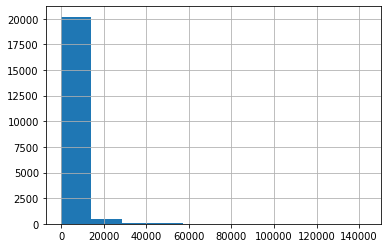

In [13]:
# посмотрим распределение длин сообщений
X_list = list(data_df['text'])

for i in range(len(X_list)):
  X_list[i] = str(X_list[i])

X_len = []
for i in range(len(X_list)):
  X_len.append(len(X_list[i]))

data_df['len'] = X_len
data_df.len.hist()

In [14]:
# let see target
data_df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

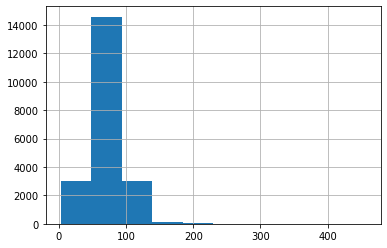

In [15]:
X_title = list(data_df['title'])

for i in range(len(X_title)):
  X_title[i] = str(X_title[i])

X_len = []
for i in range(len(X_title)):
  X_len.append(len(X_title[i]))

data_df['len2'] = X_len
data_df.len2.hist()

In [16]:
#add to dataset news about Moscow COVID-19 rank
from urllib.request import urlopen, urlretrieve
from bs4 import BeautifulSoup



In [19]:
# resp = urlopen('https://www.mos.ru/mayor/themes/14299/7238050/?utm_source=search&utm_term=serp') # скачиваем файл
# html = resp.read().decode('utf8') # считываем содержимое
# soup = BeautifulSoup(html, 'html.parser') # делаем суп
# title = soup.find('title').get_text()

# print(title)

In [ ]:
# getting all the paragraphs
body = []  #we will save information in list
for para in soup.find_all("p"):
    txt = para.get_text()
    body.append(txt)
    print(txt)

Москва вошла в топ-3 рейтинга инноваций по борьбе с COVID-19, составленного международным аналитическим центром StartupBlink, специализирующимся на исследованиях инновационных экосистем разных стран и городов мира. Об этом Сергей Собянин написал в своем блоге.
Рейтинг инноваций по борьбе с коронавирусом включает 100 городов. Российскую столицу обошли только Сан-Франциско и Нью-Йорк, а позади Москвы оказались Бостон, Торонто, Тель-Авив, Лос-Анжелес, Сеул, Тайбэй и Сан-Диего.
Еще в марте прошлого года StartupBlink в содружестве с UNAIDS, биржей инноваций в сфере здравоохранения Программы ООН по ВИЧ/СПИД, создал глобальную карту инновационных решений — открытую базу данных лучших практик по борьбе с коронавирусом в различных городах и странах мира.

Заявки на публикацию решений принимаются от аналитических центров, стартапов, компаний, городов и стран мира. Решения проходят модерацию экспертов UNAIDS. Предпочтение отдается не идеям и прототипам, а системам, которые используются на практик

In [20]:
# body = (' ').join(body)
body = '''Москва вошла в топ-3 рейтинга инноваций по борьбе с COVID-19, составленного международным аналитическим центром StartupBlink, специализирующимся на исследованиях инновационных экосистем разных стран и городов мира. Об этом Сергей Собянин написал в своем блоге.
Рейтинг инноваций по борьбе с коронавирусом включает 100 городов. Российскую столицу обошли только Сан-Франциско и Нью-Йорк, а позади Москвы оказались Бостон, Торонто, Тель-Авив, Лос-Анжелес, Сеул, Тайбэй и Сан-Диего.
Еще в марте прошлого года StartupBlink в содружестве с UNAIDS, биржей инноваций в сфере здравоохранения Программы ООН по ВИЧ/СПИД, создал глобальную карту инновационных решений — открытую базу данных лучших практик по борьбе с коронавирусом в различных городах и странах мира.

Заявки на публикацию решений принимаются от аналитических центров, стартапов, компаний, городов и стран мира. Решения проходят модерацию экспертов UNAIDS. Предпочтение отдается не идеям и прототипам, а системам, которые используются на практике.
За последний год карта стала одной из основных платформ для международного обмена опытом в борьбе с пандемией между десятками стран и сотнями городов мира.
Вклад Москвы — это 46 инновационных решений, которые помогли москвичам пережить самые трудные дни.
Эти решения обеспечили Москве третье место в престижном рейтинге, но главное — они спасли тысячи жизней людей.

Москва против COVID-19. Каким был 2020 год для здравоохранения столицы'''
print(body)

Москва вошла в топ-3 рейтинга инноваций по борьбе с COVID-19, составленного международным аналитическим центром StartupBlink, специализирующимся на исследованиях инновационных экосистем разных стран и городов мира. Об этом Сергей Собянин написал в своем блоге.
Рейтинг инноваций по борьбе с коронавирусом включает 100 городов. Российскую столицу обошли только Сан-Франциско и Нью-Йорк, а позади Москвы оказались Бостон, Торонто, Тель-Авив, Лос-Анжелес, Сеул, Тайбэй и Сан-Диего.
Еще в марте прошлого года StartupBlink в содружестве с UNAIDS, биржей инноваций в сфере здравоохранения Программы ООН по ВИЧ/СПИД, создал глобальную карту инновационных решений — открытую базу данных лучших практик по борьбе с коронавирусом в различных городах и странах мира.

Заявки на публикацию решений принимаются от аналитических центров, стартапов, компаний, городов и стран мира. Решения проходят модерацию экспертов UNAIDS. Предпочтение отдается не идеям и прототипам, а системам, которые используются на практик

In [21]:
X_authors = list(data_df['author'])

#add new author to dataset
X_authors.append('mos.ru')
#add title of news
X_title.append('Москва вошла в топ-3 рейтинга инноваций по борьбе с COVID-19 / Новости города / Сайт Москвы')
#add body of news
X_list.append(body)
#add target 0 means the news is relieble

target = list(data_df['label'])
target.append(0)
print(X_title[:-1],X_authors[:-1],X_list[:-1],target[:-1])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
print(X_title[-1],X_authors[-1],X_list[-1],target[-1])

Москва вошла в топ-3 рейтинга инноваций по борьбе с COVID-19 / Новости города / Сайт Москвы mos.ru Москва вошла в топ-3 рейтинга инноваций по борьбе с COVID-19, составленного международным аналитическим центром StartupBlink, специализирующимся на исследованиях инновационных экосистем разных стран и городов мира. Об этом Сергей Собянин написал в своем блоге.
Рейтинг инноваций по борьбе с коронавирусом включает 100 городов. Российскую столицу обошли только Сан-Франциско и Нью-Йорк, а позади Москвы оказались Бостон, Торонто, Тель-Авив, Лос-Анжелес, Сеул, Тайбэй и Сан-Диего.
Еще в марте прошлого года StartupBlink в содружестве с UNAIDS, биржей инноваций в сфере здравоохранения Программы ООН по ВИЧ/СПИД, создал глобальную карту инновационных решений — открытую базу данных лучших практик по борьбе с коронавирусом в различных городах и странах мира.

Заявки на публикацию решений принимаются от аналитических центров, стартапов, компаний, городов и стран мира. Решения проходят модерацию эксперт

In [23]:
# make new dataframe
df = pd.DataFrame(list(zip(X_title,X_authors,X_list,target)),
                  columns=['title', 'author', 'text', 'label'])
df.tail(3)

,title,author,text,label
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1
20800,Москва вошла в топ-3 рейтинга инноваций по бор...,mos.ru,Москва вошла в топ-3 рейтинга инноваций по бор...,0


In [28]:
#DIVIDE DATA TO TRAIN AND TEST
X_train, X_val, y_train, y_val = train_test_split(df[X_features], 
                                                                      df['label'],
                                                                      shuffle=True, 
                                                                      test_size=0.2,random_state=RS)

In [29]:
target_col = 'label'
text_cols = ['title','author', 'text']
categorical_cols = []

In [30]:
train = Pool(
    X_train[X_features],
    y_train,
    cat_features = categorical_cols,
    text_features = text_cols,
    feature_names=X_features,
)

In [31]:
val = Pool(
    X_val[X_features],
    y_val,
    cat_features = categorical_cols,
    text_features = text_cols,
    feature_names=X_features,
)

In [32]:
clf = CatBoostClassifier(
    iterations=100,
    depth = 11,
    learning_rate=0.2,
    loss_function='CrossEntropy',
    random_seed = RS
)

In [33]:
clf.fit(train, verbose=10)

0:	learn: 0.5312354	total: 17.4s	remaining: 28m 41s
10:	learn: 0.0700157	total: 3m 9s	remaining: 25m 33s
20:	learn: 0.0187245	total: 6m 2s	remaining: 22m 43s
30:	learn: 0.0102275	total: 8m 54s	remaining: 19m 49s
40:	learn: 0.0101085	total: 11m 45s	remaining: 16m 54s
50:	learn: 0.0095345	total: 14m 35s	remaining: 14m 1s
60:	learn: 0.0087201	total: 17m 27s	remaining: 11m 9s
70:	learn: 0.0086252	total: 20m 18s	remaining: 8m 17s
80:	learn: 0.0079065	total: 23m 10s	remaining: 5m 26s
90:	learn: 0.0073479	total: 26m 1s	remaining: 2m 34s
99:	learn: 0.0066031	total: 28m 35s	remaining: 0us


In [34]:
clf.score(val)

0.9985580389329488

In [39]:
clf.fit(val, verbose=10)

0:	learn: 0.5344744	total: 16.6s	remaining: 27m 18s
10:	learn: 0.0981001	total: 2m 22s	remaining: 19m 11s
20:	learn: 0.0356347	total: 4m 28s	remaining: 16m 48s
30:	learn: 0.0217772	total: 6m 33s	remaining: 14m 36s
40:	learn: 0.0178710	total: 8m 37s	remaining: 12m 24s
50:	learn: 0.0164568	total: 10m 42s	remaining: 10m 16s
60:	learn: 0.0149797	total: 12m 47s	remaining: 8m 10s
70:	learn: 0.0135683	total: 14m 51s	remaining: 6m 4s
80:	learn: 0.0118358	total: 16m 56s	remaining: 3m 58s
90:	learn: 0.0099311	total: 19m 1s	remaining: 1m 52s
99:	learn: 0.0084059	total: 20m 53s	remaining: 0us


In [49]:
clf.save_model('clf_cb03.cbm',
               format='cbm')

In [50]:
!ls

catboost_info  fake-news.zip  sample_data  test.csv
clf_cb03.cbm   gdrive	      submit.csv   train.csv


In [51]:
from google.colab import files
files.download('clf_cb03.cbm')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
example = [X_title[20799],X_authors[20799],X_list[20799]]
print(example)

['What Keeps the F-35 Alive', 'David Swanson', "  David Swanson is an author, activist, journalist, and radio host. He is a 2015 Nobel Peace Prize Nominee. He is director of WorldBeyondWar.com and campaign coordinator for RootsAction.org . He hosts Talk Nation Radio . Talk Nation Radio is on VT Radio and is syndicated by Pacifica Network. The show also airs on WTJU, Charlottesville, VA; WCSX-Detroit, MI; KGHI, Westport, WA; WHUS, Storrs, CT; WPRR, Grand Rapids, MI; KRFP-LP, Moscow, ID; KZGM, Cabool, MO; KMUD, Garberville, CA; WAZU, Peoria, IL; WXRD, Crown Point, IN; Geneva Radio, Geneva, NY; KKRN, Round Mountain, CA; KSKQ-LP, Ashland, OR; WUOW-LP, Oneonta, NY; No Lies Radio, Pinole, CA; WYAP-LP, Clay, WV; The Detour, Johnson City, TN; WZRD, Chicago, IL; WEFT, Champaign, IL; WXPI, Pittsburgh, PA; WDRT, Viroqua, WI; Veracity Now, online; Liberty and Justice Radio, Shirley, MA; Ithaca Community Radio, Ithaca, NY; WMCB, Greenfield, MA; PRX.org; KAOS 89.3fm, Olympia, WA; WUSB 90.1 FM, Stony

In [53]:
%time
clf.predict(example)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


1

In [54]:
%time
clf.predict_proba(example)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs


array([0.00201216, 0.99798784])